Importamos librerías necesarias y obtenemos las etiquetas a partir de la ruta de cada carpeta

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

def proc_img(filepath):
    """ Se crea un DataFrame con el path del fichero y su correspondiente etiqueta
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Se concatenan las etiquetas y los paths
    df = pd.concat([filepath, labels], axis=1)

    # Se reinician los índices
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# Se especifica cuál es el directorio de entrenamiento
train_dir = Path('./simpsons_dataset')
filepaths = list(train_dir.glob(r'**/*.jpg'))

# Obtenemos el DataFrame con las etiquetas y los paths
df = proc_img(filepaths)

print(f'Número de imágenes: {df.shape[0]}\n')
print(f'Número de etiquetas únicas: {len(df.Label.unique())}\n')
print(f'Etiquetas: {df.Label.unique()}')

# Comprobamos que se ha hecho correctamente
df.head(5)

Número de imágenes: 41866

Número de etiquetas únicas: 42

Etiquetas: ['ned_flanders' 'lisa_simpson' 'charles_montgomery_burns' 'moe_szyslak'
 'edna_krabappel' 'groundskeeper_willie' 'chief_wiggum' 'lenny_leonard'
 'kent_brockman' 'cletus_spuckler' 'marge_simpson' 'martin_prince'
 'homer_simpson' 'krusty_the_clown' 'bart_simpson' 'sideshow_bob'
 'abraham_grampa_simpson' 'comic_book_guy' 'milhouse_van_houten'
 'agnes_skinner' 'principal_skinner' 'barney_gumble'
 'apu_nahasapeemapetilon' 'otto_mann' 'sideshow_mel' 'nelson_muntz'
 'waylon_smithers' 'mayor_quimby' 'selma_bouvier' 'rainier_wolfcastle'
 'carl_carlson' 'professor_john_frink' 'snake_jailbird' 'maggie_simpson'
 'ralph_wiggum' 'patty_bouvier' 'disco_stu' 'miss_hoover' 'fat_tony'
 'troy_mcclure' 'gil' 'lionel_hutz']


,Filepath,Label
0,simpsons_dataset\ned_flanders\pic_0409.jpg,ned_flanders
1,simpsons_dataset\lisa_simpson\pic_0622.jpg,lisa_simpson
2,simpsons_dataset\simpsons_dataset\charles_mont...,charles_montgomery_burns
3,simpsons_dataset\moe_szyslak\pic_0689.jpg,moe_szyslak
4,simpsons_dataset\edna_krabappel\pic_0396.jpg,edna_krabappel


In [3]:
#Cargamos el conjunto de prueba
test_dir = Path('./kaggle_simpson_testset/')
filepaths_test = list(test_dir.glob(r'**/*.jpg'))
df_test= proc_img(filepaths_test)
df_test.head(5)

,Filepath,Label
0,kaggle_simpson_testset\abraham_grampa_simpson\...,abraham_grampa_simpson
1,kaggle_simpson_testset\nelson_muntz\nelson_mun...,nelson_muntz
2,kaggle_simpson_testset\lenny_leonard\lenny_leo...,lenny_leonard
3,kaggle_simpson_testset\krusty_the_clown\krusty...,krusty_the_clown
4,kaggle_simpson_testset\homer_simpson\homer_sim...,homer_simpson


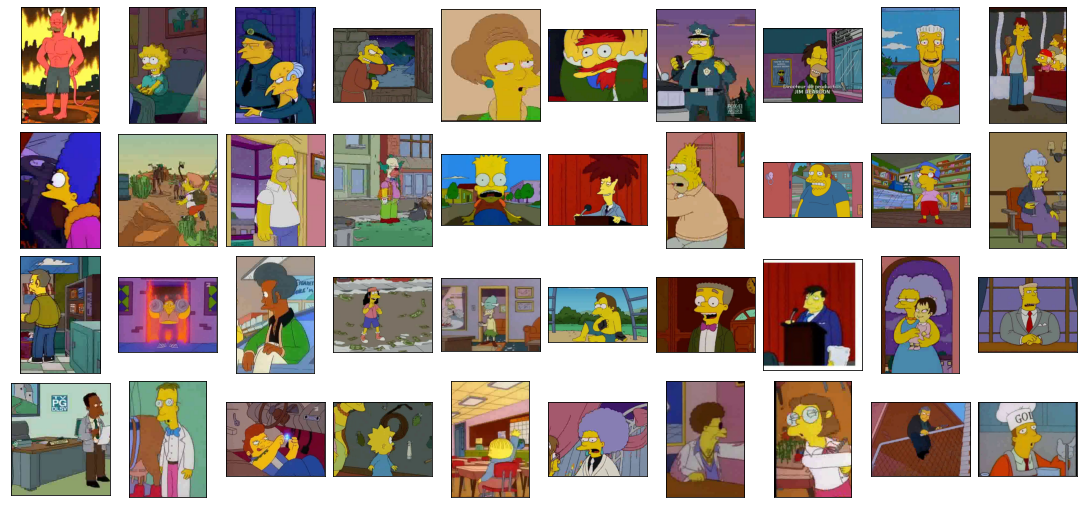

In [4]:
#Se eliminan las etiquetas duplicadas
df_unique = df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Se muestra una imagen de todos los personajes
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
plt.tight_layout(pad=0.5)
plt.show()

In [5]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [6]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 33493 validated image filenames belonging to 42 classes.
Found 8373 validated image filenames belonging to 42 classes.
Found 990 validated image filenames belonging to 20 classes.


In [12]:
#Cargamos los modelos pre-entrenados
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0

modelo_vgg16 = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet',pooling='avg')
modelo_inceptionv3 = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet',pooling='avg')
modelo_resnet50 = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet',pooling='avg')
modelo_efficientnetb0 = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet',pooling='avg')

modelo_vgg16.trainable = False
modelo_inceptionv3.trainable = False
modelo_resnet50.trainable = False
modelo_efficientnetb0.trainable = False

In [13]:
inputs = modelo_resnet50.input

x = tf.keras.layers.Dense(128, activation='relu')(modelo_resnet50.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(42, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_images, validation_data=val_images, epochs=10, batch_size=50, callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
])
model.summary()

Epoch 1/10
  36/1047 [>.............................] - ETA: 32:29 - loss: 3.7176 - accuracy: 0.0408

KeyboardInterrupt: 

In [14]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [15]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 33493 validated image filenames belonging to 42 classes.
Found 8373 validated image filenames belonging to 42 classes.
Found 990 validated image filenames belonging to 20 classes.


In [16]:
inputs = modelo_efficientnetb0.input

x = tf.keras.layers.Dense(128, activation='relu')(modelo_efficientnetb0.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(42, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_images, validation_data=val_images, epochs=10, batch_size=50, callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
])
model.summary()

Epoch 1/10
1047/1047 [==============================] - 1462s 1s/step - loss: 1.3012 - accuracy: 0.6588 - val_loss: 0.7798 - val_accuracy: 0.7983
Epoch 2/10
1047/1047 [==============================] - 1443s 1s/step - loss: 0.6316 - accuracy: 0.8273 - val_loss: 0.5843 - val_accuracy: 0.8407
Epoch 3/10
1047/1047 [==============================] - 1442s 1s/step - loss: 0.4443 - accuracy: 0.8742 - val_loss: 0.4913 - val_accuracy: 0.8670
Epoch 4/10
1047/1047 [==============================] - 1444s 1s/step - loss: 0.3367 - accuracy: 0.9017 - val_loss: 0.3993 - val_accuracy: 0.8956
Epoch 5/10
1047/1047 [==============================] - 1444s 1s/step - loss: 0.2566 - accuracy: 0.9254 - val_loss: 0.3633 - val_accuracy: 0.9018
Epoch 6/10
1047/1047 [==============================] - 1446s 1s/step - loss: 0.2155 - accuracy: 0.9363 - val_loss: 0.3143 - val_accuracy: 0.9208
Epoch 7/10
1047/1047 [==============================] - 1444s 1s/step - loss: 0.1858 - accuracy: 0.9436 - val_loss: 0.3022 -

In [17]:
# Se hace la predicción con el conjunto de test
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Se muestran los resultados
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['abraham_grampa_simpson', 'nelson_muntz', 'lenny_leonard', 'krusty_the_clown', 'homer_simpson']


In [21]:
from sklearn import metrics
y_test = list(df_test.Label)
acc = metrics.accuracy_score(y_test,pred)
print(f'Accuracy en el conjunto de prueba: {acc * 100:.2f}%')

Accuracy en el conjunto de prueba: 88.79%


In [23]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.80      0.90      0.84        48
           agnes_skinner       0.00      1.00      0.00         0
  apu_nahasapeemapetilon       0.96      1.00      0.98        50
           barney_gumble       0.00      1.00      0.00         0
            bart_simpson       0.83      0.86      0.84        50
charles_montgomery_burns       0.95      0.81      0.88        48
            chief_wiggum       0.87      0.96      0.91        50
          comic_book_guy       1.00      0.90      0.95        49
          edna_krabappel       0.98      0.86      0.91        50
    groundskeeper_willie       0.00      1.00      0.00         0
           homer_simpson       0.81      0.94      0.87        50
           kent_brockman       0.96      0.90      0.93        50
        krusty_the_clown       0.90      0.90      0.90        50
           lenny_leonard       0.98      0.86      0.91        50
         

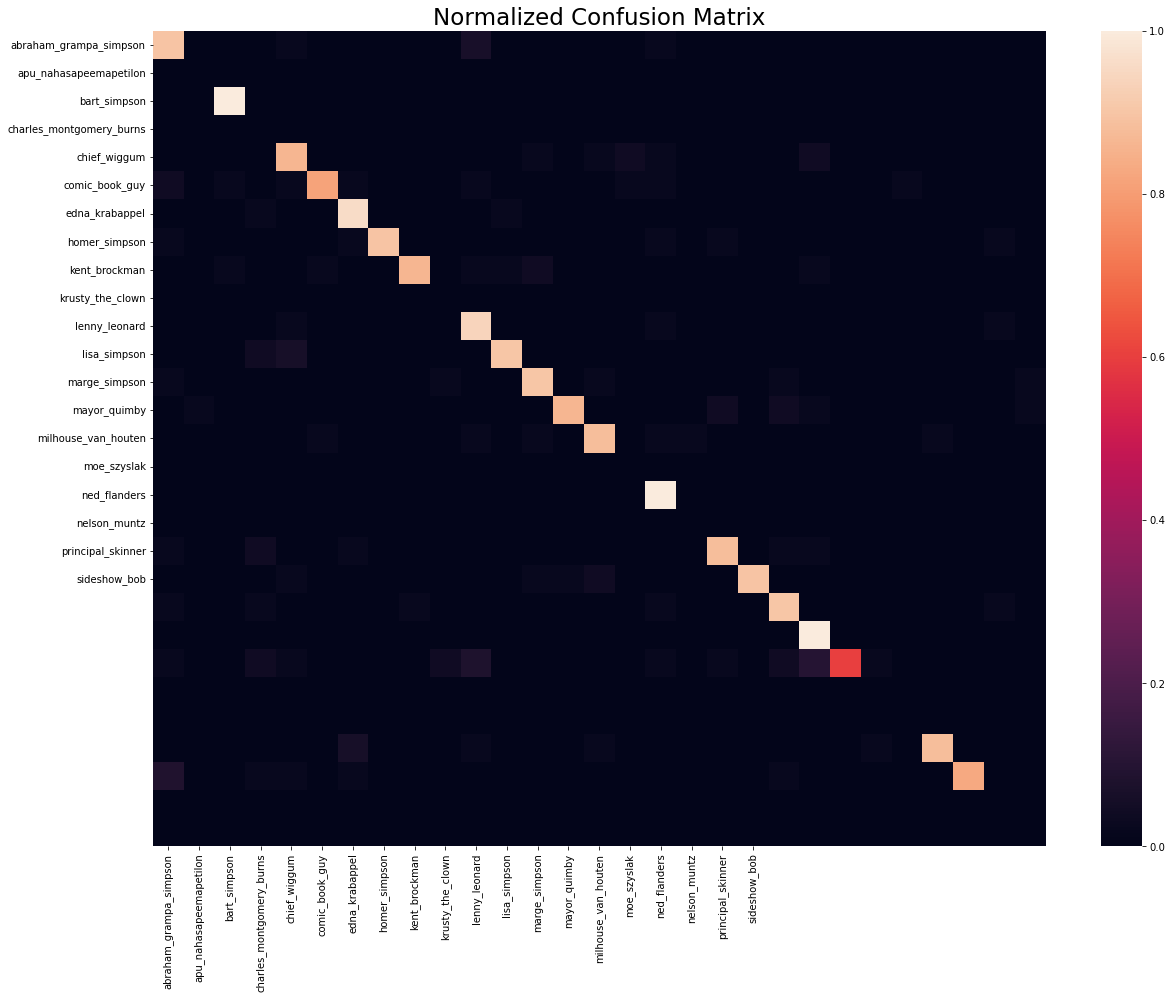

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.show()

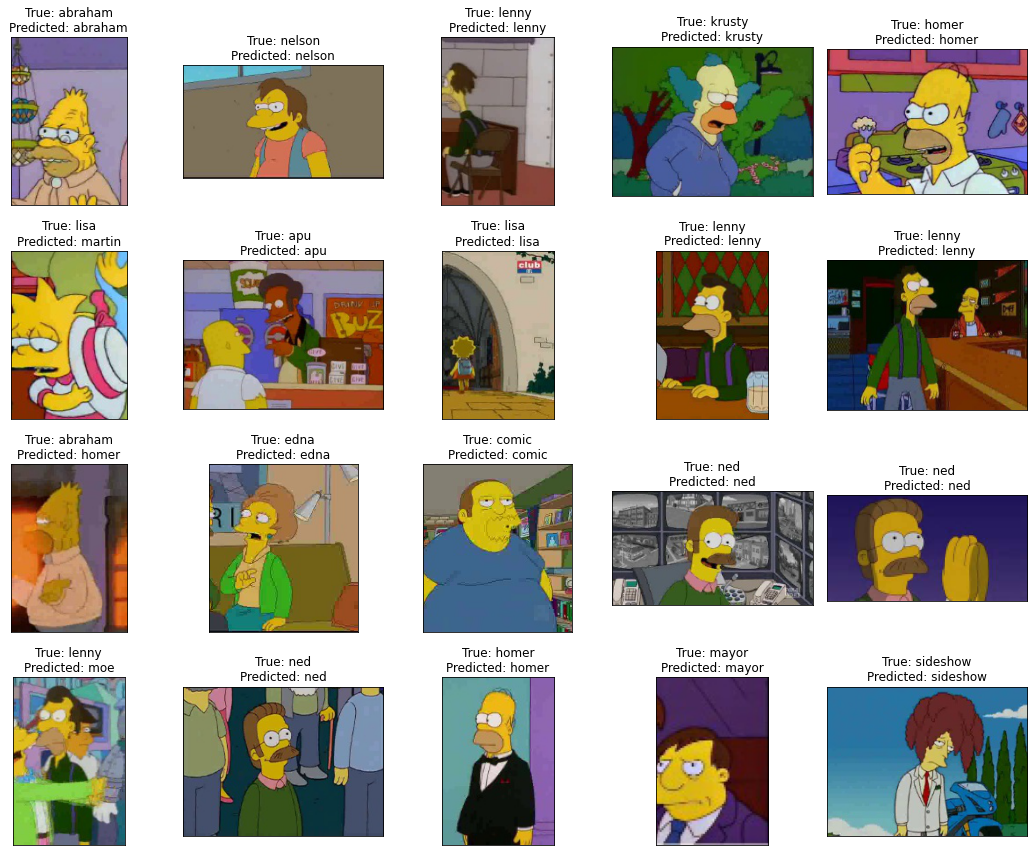

In [26]:
# Se muestran algunos resultados de la predicción
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_test.Filepath.iloc[i]))
    ax.set_title(f"True: {df_test.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()